In [1]:
import torch
from torch import nn, optim

from torchvision import datasets  # existe também o torchtext
from torchvision import transforms

import numpy as np

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

import time

args = {
    'batch_size': 100,
    'num_workers': 4,
    'num_classes': 10,
    'lr': 1e-4,
    'weight_decay': 5e-4,
    'num_epochs': 30
}

if torch.cuda.is_available():
  args['device'] = torch.device('cuda')
else:
  args['device'] = torch.device('cpu')

print(args)

{'batch_size': 100, 'num_workers': 4, 'num_classes': 10, 'lr': 0.0001, 'weight_decay': 0.0005, 'num_epochs': 30, 'device': device(type='cuda')}


In [2]:
train_set = datasets.MNIST('./',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

test_set = datasets.MNIST('./',
                           train=False,
                           transform=transforms.ToTensor(),
                           download=False)

print('Amostras de treino: ' + str(len(train_set)) + '\nAmostras de teste: ' + str(len(test_set)))

Amostras de treino: 60000
Amostras de teste: 10000


In [3]:
# O conjunto de dados é uma classe específica do dataset
# Por isso, é importante implementar uma classe sempre que formos utilizar/criar um
# Cada elemento do conjunto é uma TUPLA (dado, rótulo). O dado, nesse caso é uma imagem e o rótulo é sua classe

print(type(train_set))
print(type(train_set[0]))

<class 'torchvision.datasets.mnist.MNIST'>
<class 'tuple'>


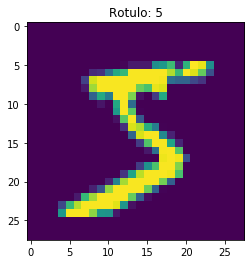

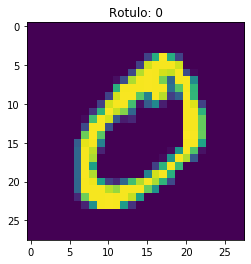

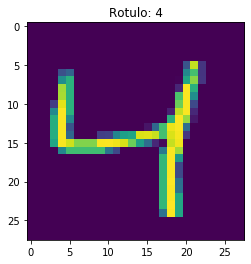

In [4]:
for i in range(3):
  dado, rotulo = train_set[i]

  plt.figure()
  plt.imshow(dado[0])
  plt.title('Rotulo: '+ str(rotulo))

In [5]:
# Podemos alterar a transformação para o RandomCrop, mostrando que podemos usar versões "recortadas" de cada imagem
# Detalhe que agora, os dados são imagens, não tensores

# train_set = datasets.MNIST('./',
#                            train=True,
#                            transform=transforms.RandomCrop(12),
#                            download=False)

# for i in range(3):
#   dado, rotulo = train_set[0]

#   print(type(dado))

#   plt.figure()
#   plt.imshow(dado)
#   plt.title('Rotulo: '+ str(rotulo))

# Dataloader

### Funcionalidade muito útil do PyTorch, que fornece as seguintes funcionalidades:

*   Separação dos dados em batches
*   Embaralhamento dos dados
*   Carregamento dos batches em paralelo utilizando *threads*


##### Sintaxe: 

```
train_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)
```

```
*   dataset: conjunto de dados de treino
*   batch_size: tamanho do batch
*   shuffle: flag do embaralhamento
*   num_workers: número de threads paralelas
```






In [6]:
train_loader = DataLoader(train_set,
                          batch_size=args['batch_size'],
                          shuffle=True)
                          #num_workers=args['num_workers']) # pode causar erro no Windows

# Obs: lembrar de utilizar a transformação transform.ToTensor() antes de executar esta célula
test_loader = DataLoader(test_set,
                          batch_size=args['batch_size'],
                          shuffle=True)
                          #num_workers=args['num_workers']) # pode causar erro no Windows

torch.Size([100, 1, 28, 28]) torch.Size([100])


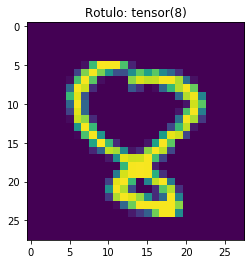

In [7]:
for batch in train_loader:

  dado, rotulo = batch
  print(dado.size(), rotulo.size())

  plt.imshow(dado[0][0])
  plt.title('Rotulo: ' + str(rotulo[0]))

  break

In [8]:
class MLP(nn.Module):

    def __init__(self, in_size, hid_size, out_size):
        super(MLP, self).__init__()

        self.features = nn.Sequential(nn.Linear(in_size, hid_size),
                                      nn.ReLU(),
                                      nn.Linear(hid_size, hid_size),
                                      nn.ReLU()
                                      )
        self.out      = nn.Linear(hid_size, out_size)
        self.softmax  = nn.Softmax()

    def forward(self, X):

        X = X.view(X.size(0), -1) # redimensiona o tensor. Nesse caso, mantém a 1a dimensão e lineariza o restante

        feature = self.features(X)
        output = self.softmax(self.out(feature))

        return output

In [9]:
in_size  = 28 * 28 # número total de pixels das imagens de entrada
hid_size = 128
out_size = 10 # dígitos de 0 a 9

In [10]:
torch.manual_seed(42)
net = MLP(in_size, hid_size, out_size).to(args['device'])

In [11]:
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

In [ ]:
for epoch in range(args['num_epochs']):   # épocas

    epoch_loss = []
    start = time.time()
    
    for batch in train_loader:              # iterações
    
        dado, rotulo = batch

        # Cast na GPU
        dado = dado.to(args['device'])
        rotulo = rotulo.to(args['device'])

        # Forward
        pred = net(dado)                       # passa os dados pela rede
        loss = criterion(pred, rotulo)         # calcula o valor da perda
        epoch_loss.append(loss.cpu().data)     # adiciona o valor da perda atual à lista

        #Backward
        loss.backward()                        # calcula o gradiente
        optimizer.step()                       # atualização dos pesos

    epoch_loss = np.asarray(epoch_loss)
    end = time.time()

    print('Epoca: %d, Loss: %.4f +\- %.4f, Time: %d' % (epoch, epoch_loss.mean(), epoch_loss.std(), int(end-start)))

C:\Users\Claudio\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoca: 0, Loss: 1.8887 +\- 0.1898, Time: 25
Epoca: 1, Loss: 1.6822 +\- 0.0457, Time: 19
Epoca: 2, Loss: 1.6412 +\- 0.0409, Time: 19
Epoca: 3, Loss: 1.6338 +\- 0.0380, Time: 19
Epoca: 4, Loss: 1.6345 +\- 0.0395, Time: 19
Epoca: 5, Loss: 1.6261 +\- 0.0368, Time: 20
Epoca: 6, Loss: 1.6278 +\- 0.0375, Time: 21
Epoca: 7, Loss: 1.6262 +\- 0.0379, Time: 19
Epoca: 8, Loss: 1.6348 +\- 0.0384, Time: 19
Epoca: 9, Loss: 1.6359 +\- 0.0375, Time: 20
Epoca: 10, Loss: 1.6327 +\- 0.0381, Time: 20
Epoca: 11, Loss: 1.6526 +\- 0.0425, Time: 20
Epoca: 12, Loss: 1.6602 +\- 0.0415, Time: 19
Epoca: 13, Loss: 1.6341 +\- 0.0372, Time: 19
Epoca: 14, Loss: 1.6373 +\- 0.0402, Time: 19
Epoca: 15, Loss: 1.6459 +\- 0.0397, Time: 19
Epoca: 16, Loss: 1.6491 +\- 0.0395, Time: 19
Epoca: 17, Loss: 1.6432 +\- 0.0381, Time: 20
Epoca: 18, Loss: 1.6432 +\- 0.0396, Time: 20
Epoca: 19, Loss: 1.6358 +\- 0.0381, Time: 20
Epoca: 20, Loss: 1.6627 +\- 0.0426, Time: 20
Epoca: 21, Loss: 1.6862 +\- 0.0431, Time: 19
Epoca: 22, Loss: 1.6